### Introduction:

Baseball is an incredibly popular sport, also known as America's pasttime. For many watching from home, the true size of baseball players may be a mystery. Some tower over the masses, such as Aaron Judge at 6'7", others, like Jose Altuve, are an unassuming 5'6". Like in many other sports, great athletes can excel in baseball through hard work and talent, no matter their size. However, the question still lingers, what is the height and weight the average MLB player? Or perhaps more importantly, what combination of height and weight tends to produce the most successful ballplayers? These are all questions which I attempt to answer in this project.

Additionally, with salary data, I hope to answer additional questions such as the value of both WAR (Wins Above Replacement) and RC (Runs Created), and finally, attempt to predict WAR using a combination of statistics.

Statistics such as Wins Above Replacement and Runs Created aim to provide a means of measurement regarding a player's ability to contribute to his team, and are a good reference of a player's production within the game of baseball. This project will only focus on offensive statistics for simplicity (WAR, and especially RC, are better at measuring hitter and fielder production), as well as primarily use Wins Above Replacement as a benchmark for how good a player is. A simple rundown of a WAR score is as follows: 0-2 refers to a basic level player, 2-4 is a fringe all-star, 4-6 is an all-star/superstar, a 6+ war means a player is typically having a career-defining season. 

*For reference, this year (2022)'s American League MVP, Aaron Judge, hit a league-record 62 home runs and racked up a WAR of 10.6, the next closest player is generational dual-threat talent Shohei Ohtani with 9.6. Only one man outside the top 5 players in WAR has a WAR of above 7.0.*

Runs Created, on the other hand, is simply a mathematical formula developed by famed baseball statistician Bill James to measure, roughly, how many runs a player was able to create over a given time span. In the context of this project, we examine a single season.

In summary, this project aims to use 2021 hitting data to achieve two things:
1. Find the most ideal build for an MLB player, according to WAR.
2. Determine, if possible, the dollar value of one unit of WAR and/or RC.

### Data:

The data used in this project come from two sources, lahman's baseball database and baseball-reference.com. Due to this discrepancy, the number of players with available salary statistics is quite limited compared to those available for analysis when looking purely at batting statistics. (lahman's database is quite extensive, as is baseball-reference.com. However, salary information is only available for a select number of players, a majority of whom are pitchers and aren't included in this project).

The Salaries.csv is copied directly from baseball-reference.com using the csv conversion tools provided on the website; baseball-reference.com is listed in the references section of this project.

In practice, datasets like the ones attached below are used by ballclubs around the league to evaluate players. The statistics contained within the batting.csv file are only those which can be observed and recorded with the naked eye. These are well-known stats such as hits (H), walks (BB), and strike-outs (SO). Slightly more advanced stats, such as batting average (BA), on-base percentage (OBS), or even runs created (RC), can be generated from these numbers, as will be demonstrated below. The most important value, however, is "playerID", a unique ID which exists for every player and enables their statistics to be cross referenced throughout any dataset. "playerID" will be invaluable for merging different datasets and ensuring that numbers from a different source or csv will always be matched up correctly for analysis. Finally, one note to be made is that only players with more than 100 ABs in a season were selected to be part of the final two datasets (total21 and final21), this is because the average starter in the league takes approximately 300 to 400 at bats in a season, players with under 100 ABs are likely to have less of a main role on the team and are out of the scope of this project, which is strictly looking at players of starting quality.

Immediately below is a snippet of the batting dataset, from which most of the data for analysis is sourced:

In [1]:
#import libraries
import pandas as pd

#reading CSVs into python
people = pd.read_csv("baseballdatabank-2022.2 2/core/People.csv")
batting = pd.read_csv("baseballdatabank-2022.2 2/core/Batting.csv")
#salaries.csv copied from baseball-reference.com
salaries = pd.read_csv("Salaries.csv")
#the dataset runs from 1871~ filter to display more relevant results
batting[batting["yearID"] >= 2021].head()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
108789,abadfe01,2021,1,BAL,AL,16,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
108790,abbotco01,2021,1,CHN,NL,8,3,0,1,0,...,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0
108791,abreual01,2021,1,NYA,AL,28,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
108792,abreubr01,2021,1,HOU,AL,31,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
108793,abreujo02,2021,1,CHA,AL,152,566,86,148,30,...,117.0,1.0,0.0,61,143.0,3.0,22.0,0.0,10.0,28.0


### Methodology: 

In this project, after some basic, graph-based data analysis using scatter plots and violin plots, I will use Principle Component Analysis in tandem with KMeans clustering to cluster the data in search of trends or anomalies. Finally, I will use linear regression techniques to perform regression on a number of factors to predict both WAR and RC, as well as salary, depending on trends observed in the aforementioned PCA and clustering process.

Principle Component Analysis (PCA) is a method of transforming data where its dimensions are reduced while simultaneously capturing the maximum variance in the data. Linear Regression is a method of fitting a single line to a two-dimensional (or multidimensional) data and make predictions using within the range of the data. In this project, we will conduct linear regression using a formula based on matrix transformation and multiplication. 

This strategy of analyzing data was chosen because there are many statistics relating to a player's performance on the field, and PCA would be the perfect technique to implement in order to reduce the dimensionality of my dataset and make it more presentable for further clustering and analysis. Implementing PCA with clustering would enable me to visualize the on-field performance of players and make subsequent connections between players that would not be possible from simply skimming the dataframe.

The use of linear regression helps make predictions regarding player performance within a certain range. Moreover, by plotting the results of linear regression against actual values, we can also observe the predictive power of certain statistics. For example, we can determine how well a players WAR can be predicted using both derived and basic statistics, or determine how much WAR or RC are worth based upon the regression results and interpreting the coefficients of the results.

### Analysis:

In [2]:
people1 = people[["playerID","nameFirst","nameLast","weight","height"]]

#filter out statistics before 2021 (last year in dataset)
batting21 = batting.loc[(batting["yearID"] == 2021)]

#collapse the data for players who were on multiple teams in 2021 (csv contains more than one row for their stats)
statistics = ["playerID","G","AB","R","H","2B","3B","HR","RBI","SB","CS","BB","SO","IBB","HBP","SH","SF","GIDP"]
stats21 = batting21[statistics]
stats21_sum = stats21.groupby('playerID', as_index = False).sum()

#filter out players with less than 100 At Bats (ABs)
filtered21 = stats21_sum.loc[(stats21_sum["AB"] >= 100)]

#removing the dollar sign to make salaries comparable
salaries["Salary"] = salaries["Salary▼"].str.replace("$", "")
salaries["Salary"] = salaries["Salary"].astype(int)

/var/folders/k6/97s742cj1sxgx6xqkr3d9dbr0000gn/T/ipykernel_80387/744714121.py:15: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  salaries["Salary"] = salaries["Salary▼"].str.replace("$", "")


In [3]:
#create columns for Batting Average (BA), On-Base Percentage (OBP), Slugging (SLG), OPS (On-Base+Slugging)
s = filtered21 #s for "sabermetrics" (these statistics aren't necessarily sabermetric but its a fun represenation)
s["BA"] = s["H"]/s["AB"]
s["OBP"] = (s["H"]+s["BB"]+s["HBP"])/(s["AB"]+s["BB"]+s["HBP"]+s["SF"])
s["SLG"] = ((s["H"]-s["2B"]-s["3B"]-s["HR"]) + 2*s["2B"] + 3*s["3B"] + 4*s["HR"])/s["AB"]
s["OPS"] = s["OBP"] + s["SLG"]
#new statistic, Runs Created (RC)
s["RC"] = ((s["H"]+s["BB"]+s["HBP"]-s["CS"]-s["GIDP"])*
(((s["H"]-s["2B"]-s["3B"]-s["HR"])+2*s["2B"]+3*s["3B"]+4*s["HR"])+0.26*(s["BB"]-s["HBP"]+s["IBB"])
+0.52*(s["SH"]+s["SF"]+s["SB"])))/(s["AB"]+s["BB"]+s["HBP"]+s["SH"]+s["SF"])

/var/folders/k6/97s742cj1sxgx6xqkr3d9dbr0000gn/T/ipykernel_80387/1734059794.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s["BA"] = s["H"]/s["AB"]
/var/folders/k6/97s742cj1sxgx6xqkr3d9dbr0000gn/T/ipykernel_80387/1734059794.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s["OBP"] = (s["H"]+s["BB"]+s["HBP"])/(s["AB"]+s["BB"]+s["HBP"]+s["SF"])
/var/folders/k6/97s742cj1sxgx6xqkr3d9dbr0000gn/T/ipykernel_80387/1734059794.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [4]:
#create a final table with relevant baseball statistics combined with biographical information
total21 = s.merge(people1, on = "playerID")
#check for null values
print(total21.isnull().sum())

playerID     0
G            0
AB           0
R            0
H            0
2B           0
3B           0
HR           0
RBI          0
SB           0
CS           0
BB           0
SO           0
IBB          0
HBP          0
SH           0
SF           0
GIDP         0
BA           0
OBP          0
SLG          0
OPS          0
RC           0
nameFirst    0
nameLast     0
weight       0
height       0
dtype: int64


In [5]:
#extract just player name and their salary from salaries.csv
salaries1 = salaries[["Name", "WAR", "Salary"]]
salaries1["playerID"] = salaries["Name-additional"]

#combine salaries1 with the total player statistics dataframe
tot_w_sal21 = total21.merge(salaries1, how = "left", on = "playerID")

#check how many players are missing salary numbers
print(tot_w_sal21.isnull().sum())

#create final dataset
final21 = tot_w_sal21.dropna()
final21.head()

playerID       0
G              0
AB             0
R              0
H              0
2B             0
3B             0
HR             0
RBI            0
SB             0
CS             0
BB             0
SO             0
IBB            0
HBP            0
SH             0
SF             0
GIDP           0
BA             0
OBP            0
SLG            0
OPS            0
RC             0
nameFirst      0
nameLast       0
weight         0
height         0
Name         206
WAR          206
Salary       206
dtype: int64


/var/folders/k6/97s742cj1sxgx6xqkr3d9dbr0000gn/T/ipykernel_80387/2356468560.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salaries1["playerID"] = salaries["Name-additional"]


,playerID,G,AB,R,H,2B,3B,HR,RBI,SB,...,SLG,OPS,RC,nameFirst,nameLast,weight,height,Name,WAR,Salary
0,abreujo02,152,566,86,148,30,2,30,117.0,1.0,...,0.480565,0.831096,88.913384,Jose,Abreu,235.0,75.0,José Abreu,3.0,17666666.0
1,acunaro01,82,297,72,84,19,1,24,52.0,17.0,...,0.595960,0.990404,75.313778,Ronald,Acuna,205.0,72.0,Ronald Acuna Jr.,3.6,5000000.0
4,adriaeh01,109,182,32,45,9,2,5,28.0,0.0,...,0.401099,0.728022,24.503732,Ehire,Adrianza,195.0,73.0,Ehire Adrianza#,0.3,1500000.0
5,aguilje01,131,449,49,117,23,0,22,93.0,0.0,...,0.458797,0.787510,68.095644,Jesus,Aguilar,277.0,75.0,Jesus Aguilar,1.4,4300000.0
6,ahmedni01,129,434,46,96,30,3,5,38.0,7.0,...,0.338710,0.618964,41.262791,Nick,Ahmed,201.0,74.0,Nick Ahmed,0.7,7875000.0


In [6]:
#import Matplotlib and numpy for plotting and analysis
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Due to the fact that WAR statistics are only available for players in the salary CSV (206 fewer than those who are included in just the batting.csv), many graphs within this porject will display statistics measured by OPS on the y-axis instead. Although not as advanced as WAR, OPS (a combination of on base percentage and slugging, which is a player's hits weighted by how many bases they travel, ex. 1 for a single, 4 for a home-run.) is still a strong indicator of player performance and works well to provide observable data for significantly more points than if we just relied on WAR.

#### Exploratory Data Analysis
Here we begin the exploratory data analysis, starting with the total21 dataframe and moving on to the final21 dataframe as we attempt to predict WAR. We start with the distribution of height, then move to weight, and finally attempt to present both while searching for the combination which produces, on average, the highest WAR.

In [7]:
#determine how many players per height
print(total21.groupby(["height"]).size())

height
66.0     2
67.0     1
68.0    12
69.0    15
70.0    38
71.0    45
72.0    80
73.0    80
74.0    70
75.0    49
76.0    39
77.0    15
78.0     2
79.0     2
dtype: int64


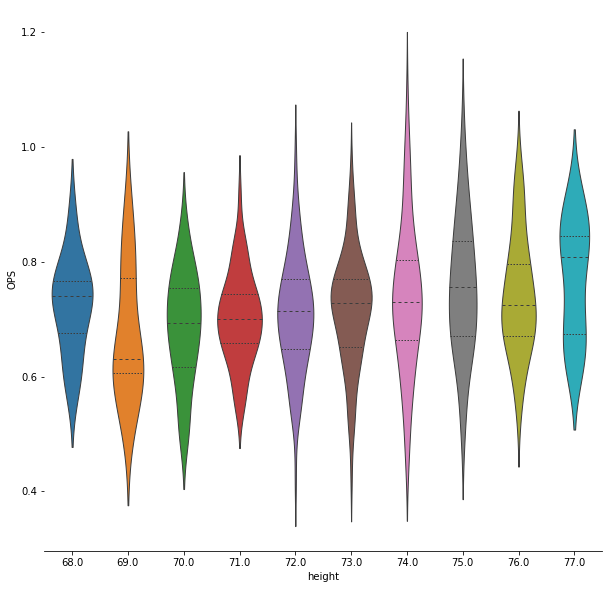

In [8]:
#create a new dataframe eliminating outlying players on either end 
#(results in at least 10 players per height)
height_lim = total21.loc[(total21["height"] >= 68) & (total21["height"] <= 77)]
data = height_lim[["height", "OPS"]]
plt.figure(figsize = (10,10))
# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(data=data, x="height", y="OPS", inner = "quart", linewidth=1)
sns.despine(left=True)

<AxesSubplot:xlabel='weight', ylabel='OPS'>

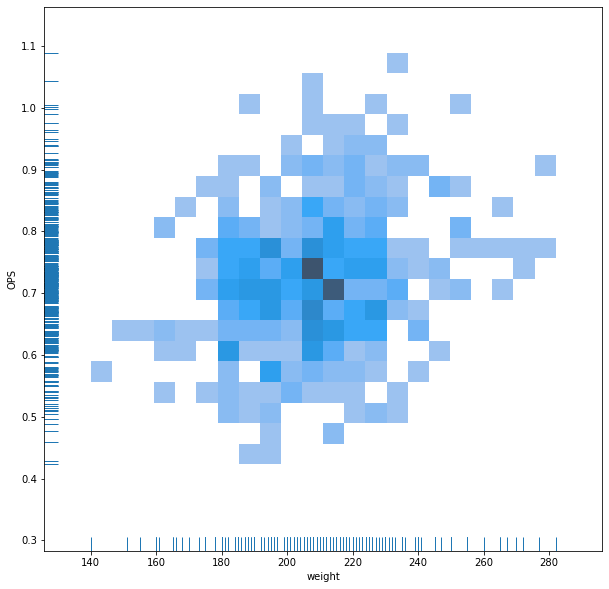

In [9]:
#distribution of weight and OPS
plt.figure(figsize = (10,10))
sns.histplot(data=total21, x = "weight", y = "OPS")
#rugplot gives a good reference for the distribution of player weight
sns.rugplot(data=total21, x = "weight", y = "OPS")

Here we begin the analysis of height and weight using more conventional methods, such as taking the average WAR of all height and weight combinations, as well as taking the average WAR of height and weight separately. The ultimate goal is to find a combination with the highest WAR.

In [10]:
#find the combinations of height and weight which exist in the dataset, calculate average WAR for said height and weight
war = final21[["height", "weight","WAR"]].groupby(["height","weight"]).agg({"WAR":"mean"})
#find highest average WAR
print("The highest WAR for height and weight when calculated together is:", war["WAR"].max())
print(final21.loc[(final21["height"] == 72) & (final21["weight"] == 195), ["nameFirst", "nameLast", "WAR"]])

The highest WAR for height and weight when calculated together is: 7.3
    nameFirst nameLast  WAR
365    Marcus   Semien  7.3


In [11]:
#highest mean WAR by height, first we eliminate heights with under 10 players
war_height1 = final21[["height", "weight","WAR"]].groupby(["height"])
#figure out how many players per height
print(war_height1.size())
#new height dataframe
height_lim = final21.loc[(final21["height"] >= 70) & (final21["height"] <= 76)]
war_height = height_lim[["height", "weight","WAR"]].groupby(["height"])
#find the mean WAR at each height
print(war_height.agg({"WAR":"mean"}))
#find the highest mean WAR
print(war_height.agg({"WAR":"mean"}).idxmax())
#find a list of the players who are listed at this height
print(final21.loc[final21["height"] == 74, ["nameFirst", "nameLast", "WAR"]])

height
66.0     2
67.0     1
68.0     5
69.0     7
70.0    13
71.0    23
72.0    34
73.0    48
74.0    43
75.0    33
76.0    25
77.0     8
78.0     1
79.0     1
dtype: int64
             WAR
height          
70.0    1.200000
71.0    1.213043
72.0    1.570588
73.0    1.412500
74.0    2.230233
75.0    1.718182
76.0    1.388000
WAR    74.0
dtype: float64
     nameFirst   nameLast  WAR
6         Nick      Ahmed  0.7
22       Nolan    Arenado  4.1
43      Xander   Bogaerts  4.9
48     Michael   Brantley  2.5
54       Byron     Buxton  4.5
57     Lorenzo       Cain  2.2
62        Mark      Canha  2.5
66        Curt     Casali  0.7
70     Starlin     Castro  1.1
87       J. P.   Crawford  3.8
90      Nelson       Cruz  2.5
92       David       Dahl -1.0
94      Travis   d'Arnaud  0.2
106       Alex  Dickerson -0.1
112       Matt      Duffy  1.6
119       Adam      Engel  1.6
127     Wilmer     Flores  1.7
149        Yan      Gomes  2.5
157    Yasmani    Grandal  3.7
159     Randal    Grichuk 

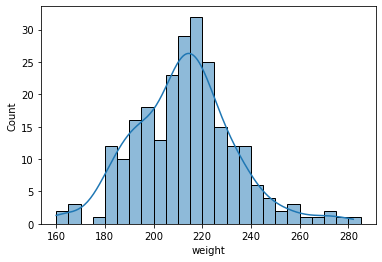

In [12]:
#using a weight histogram to determine how to narrow down the distribution
sns.histplot(data=final21, x = "weight", binwidth = 5, kde = True)

#create a new variable containing ranges of weights (ex. 200 = 200~204.999)
weights = list(range(160,290,5))
for i in range(len(weights)-1):
    for weight in final21["weight"]:
        if (int(weight) >= weights[i]) & (int(weight) < weights[i+1]):
            final21.loc[final21["weight"]==weight, ["weight_agg"]] = weights[i]

In [13]:
#highest mean WAR by height, first we eliminate heights with under 10 players
war_weight1 = final21[["height", "weight_agg","WAR"]].groupby(["weight_agg"])
#figure out how many players per weight range
print(war_weight1.size())
#new weight dataframe
weight_lim = final21.loc[(final21["weight_agg"] >= 180) & (final21["weight_agg"] <= 235)]
war_weight = weight_lim[["height", "weight_agg","WAR"]].groupby(["weight_agg"])
#find the mean WAR at each weight
print(war_weight.agg({"WAR":"mean"}))
#find the highest mean WAR
print(war_weight.agg({"WAR":"mean"}).idxmax())
#find a list the players who are listed at this weight
print(final21.loc[final21["weight_agg"] == 190, ["nameFirst", "nameLast", "WAR"]])

weight_agg
160.0     2
165.0     3
175.0     1
180.0    12
185.0    10
190.0    16
195.0    18
200.0    13
205.0    23
210.0    29
215.0    32
220.0    25
225.0    15
230.0    12
235.0    12
240.0     6
245.0     4
250.0     2
255.0     3
260.0     1
265.0     1
270.0     2
275.0     1
280.0     1
dtype: int64
                 WAR
weight_agg          
180.0       0.683333
185.0       2.630000
190.0       2.706250
195.0       1.805556
200.0       0.823077
205.0       1.195652
210.0       1.696552
215.0       1.953125
220.0       2.092000
225.0       1.680000
230.0       1.575000
235.0       1.025000
WAR    190.0
dtype: float64
     nameFirst      nameLast  WAR
29      Javier          Baez  4.5
31      Tucker      Barnhart  0.2
49        Alex       Bregman  2.1
54       Byron        Buxton  4.5
112       Matt         Duffy  1.6
121    Eduardo       Escobar  2.4
138     Freddy        Galvis  1.2
142      Leury        Garcia  2.1
172       Josh      Harrison  2.1
179    Enrique     Hernand

In [14]:
#find a player from the height and weight with highest respective mean WAR
info = ["nameFirst","nameLast","WAR","height","weight"]
players = final21.loc[(final21["height"] == 74) & (final21["weight_agg"] == 190), info]
print(players)
print("Mean WAR among players of 74 inches and 190lbs of weight:", players["WAR"].mean())

    nameFirst nameLast  WAR  height  weight
54      Byron   Buxton  4.5    74.0   190.0
112      Matt    Duffy  1.6    74.0   190.0
348      Amed  Rosario  1.9    74.0   190.0
Mean WAR among players of 74 inches and 190lbs of weight: 2.6666666666666665


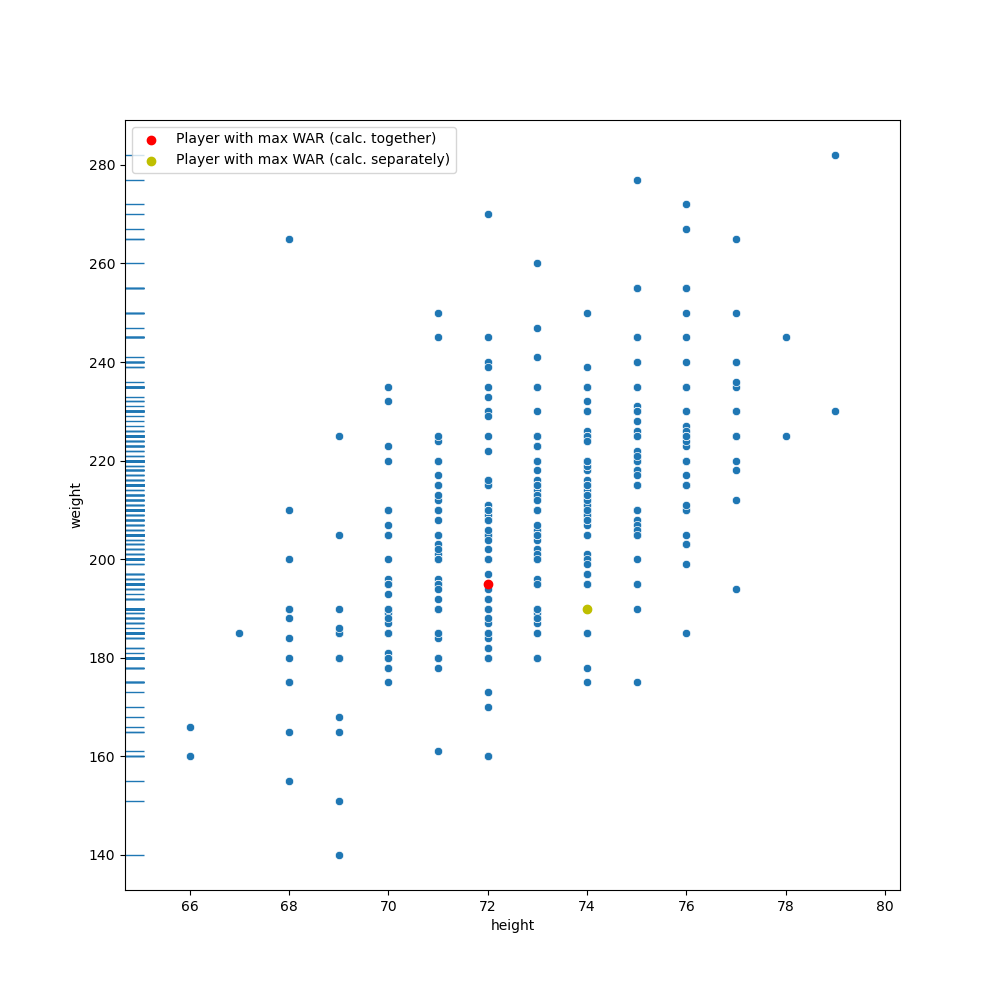

In [35]:
plt.figure(figsize = (10,10))
sns.scatterplot(data=total21, x = "height", y = "weight")
plt.scatter(data=total21, x = 72, y = 195, c = "r", label = "Player with max WAR (calc. together)")
plt.scatter(data=total21, x = 74, y = 190, c = "y", label = "Player with max WAR (calc. separately)")
sns.rugplot(data=total21, y = "weight")
plt.legend()

Text(0.5, 1.0, 'Heatmap of Height, Weight, and WAR')

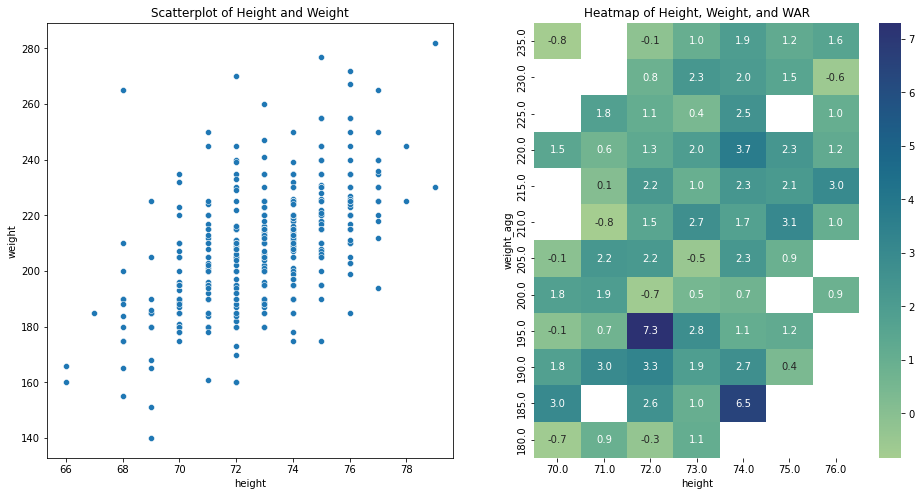

In [16]:
war_hw = weight_lim[["height", "weight_agg","WAR"]]
table = pd.pivot_table(war_hw, values = "WAR", index = "weight_agg", columns = "height", aggfunc = np.mean)
#limit table by height, given that weight is already limited in weight_lim
table_lim = table[[column for column in table.columns if (column >= 70) & (column <= 76)]]

#plot visualizations of all this math!
fig, axes = plt.subplots(1, 2, figsize=(16,8))
sns.scatterplot(ax=axes[0], data=total21, x = "height", y = "weight")
axes[0].set_title("Scatterplot of Height and Weight")
sns.heatmap(ax=axes[1], data=table_lim, annot=True, fmt=".1f", cmap="crest")
axes[1].invert_yaxis()
axes[1].set_title("Heatmap of Height, Weight, and WAR")

#### Clustering
Now we begin analysis of the data using techniques learned in class, continuing with height and weight, a 3D graph will be constructed, along with a clustering of points using the KMeans algorithm, which will enable a better visualization of the data. This is slightly different from the methods used above, as now we are looking for players with relatively similar heights, weights, and WAR, whereas previously we were looking for heights and weights either in exact combinations or within a range of 5 pounds.

We will also cluster players based upon basic and derived stats, using PCA to reduce dimensionality in the process, in an attempt to better visualize similar players in the form of a 2D scatterplot. Basic refers to any statistic which was already present in the initial lahman dataset, while derived refers to statistics which were calculated in this notebook.

For each clustering result, we generate summary statistics which help characterize the players within each cluster, and also allows us to gain a stronger comprehension of the way the points are distributed in the final 2D plot.

In [17]:
#import libraries and initialize scaler
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

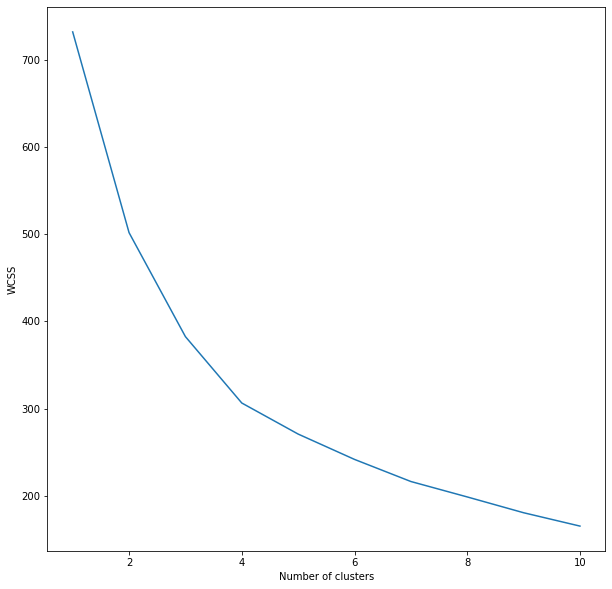

In [18]:
#clustering based on height weight and WAR for some visualization
scaler.fit(final21[["height", "weight","WAR"]])
#transform the data so each variable is weighted equally
war_scaled = scaler.transform(final21[["height", "weight","WAR"]])

#Elbow Method for finding optimum number of clusters
wcss = []
for i in range(1,11):
    model = KMeans(n_clusters = i, init = "k-means++")
    model.fit(war_scaled)
    wcss.append(model.inertia_)

#Plot Graph
plt.figure(figsize=(10,10))
plt.plot(range(1,11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Text(0.5, 0, 'WAR')

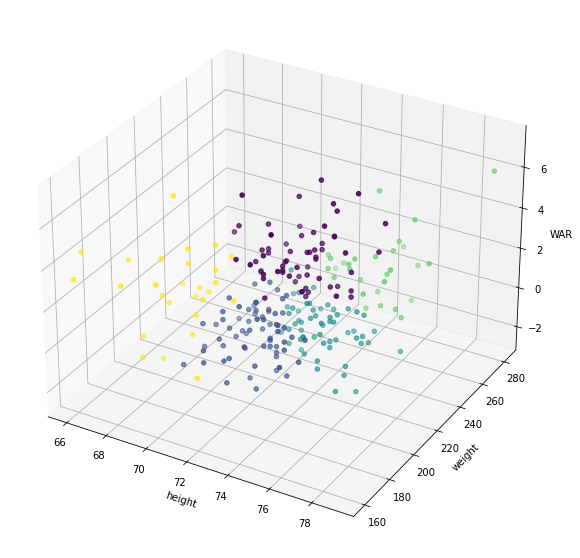

In [19]:
#from the wcss graph, 4~7 clusters seem ideal
#since there are already only three dimensions to this data, we won't use PCA to further reduce its dimensions
km = KMeans(n_clusters = 5)
war_labels = km.fit_predict(war_scaled)

plt.figure(figsize = (10,10))
ax = plt.axes(projection = '3d')
ax.scatter3D(final21["height"], final21["weight"], final21["WAR"], c = war_labels)
ax.set_xlabel('height')
ax.set_ylabel('weight')
ax.set_zlabel('WAR')

In [20]:
#print the min, max, and mean height, weight, and WAR of players in each cluster
final21["war_labels"] = war_labels
for i in final21["war_labels"].unique():
    players = final21.loc[final21["war_labels"] == i, ["nameFirst","nameLast", "height", "weight", "WAR"]]
    print("Statistics for height, weight, & WAR for cluster {}:".format(i))
    print(players.agg({"height":["min","max","mean"],"weight":["min","max","mean"],"WAR":["min","max","mean"]}))

Statistics for height, weight, & WAR for cluster 3:
         height      weight       WAR
min   72.000000  225.000000 -0.500000
max   79.000000  282.000000  6.000000
mean  75.517241  246.137931  2.193103
Statistics for height, weight, & WAR for cluster 0:
         height      weight       WAR
min   70.000000  185.000000  2.100000
max   77.000000  240.000000  7.300000
mean  73.714286  212.714286  3.968254
Statistics for height, weight, & WAR for cluster 1:
         height      weight       WAR
min   70.000000  175.000000 -1.900000
max   75.000000  235.000000  2.100000
mean  72.179104  201.268657  0.408955
Statistics for height, weight, & WAR for cluster 4:
         height      weight       WAR
min   66.000000  160.000000 -0.700000
max   72.000000  210.000000  6.700000
mean  69.321429  184.678571  2.542857
Statistics for height, weight, & WAR for cluster 2:
         height      weight       WAR
min   72.000000  203.000000 -2.500000
max   77.000000  241.000000  1.700000
mean  74.315789  2

/var/folders/k6/97s742cj1sxgx6xqkr3d9dbr0000gn/T/ipykernel_80387/1360938417.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final21["war_labels"] = war_labels


Text(0.5, 1.0, 'WCSS of Basic Dataset')

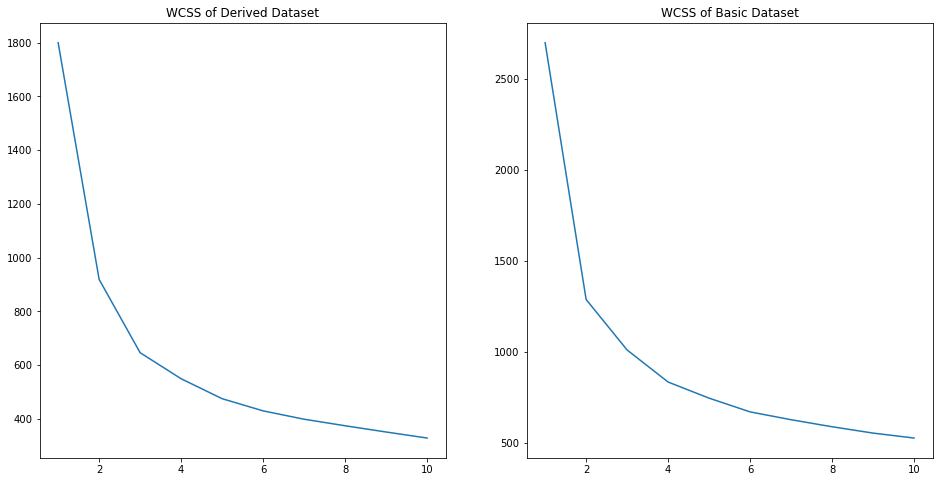

In [21]:
#lists of stats to transform using PCA and later use in Linear Regression
basic = ["H","HR","RBI","SB","SO","BB",]
derived = ["BA", "OBP", "SLG", "RC"]

#salary inclusive with some of the biggest offensive indicators
sal_inclusive = ["OPS", "WAR", "RC", "Salary"]

#scale each subset of data
scaler.fit(total21[derived])
derived_scaled = scaler.transform(total21[derived])

scaler.fit(total21[basic])
basic_scaled = scaler.transform(total21[basic])

scaler.fit(total21[basic+derived+["height","weight"]])
total_scaled = scaler.transform(total21[basic+derived+["height","weight"]])

#generate WCSS plot for cluster determination
wcss_d = []
wcss_b = []
for data in [("derived", derived_scaled), ("basic", basic_scaled)]:
    for i in range(1,11):
        model = KMeans(n_clusters = i, init = "k-means++")
        model.fit(data[1])
        if data[0] == "derived":
            wcss_d.append(model.inertia_)
        else:
            wcss_b.append(model.inertia_)
#two subplots
fig, axes = plt.subplots(1, 2, figsize=(16,8))
sns.lineplot(ax = axes[0], x = range(1,11), y = wcss_d)
axes[0].set_title("WCSS of Derived Dataset")
sns.lineplot(ax = axes[1], x = range(1,11), y = wcss_b)
axes[1].set_title("WCSS of Basic Dataset")

[Text(0.5, 1.0, 'PCA of Derived Stats')]

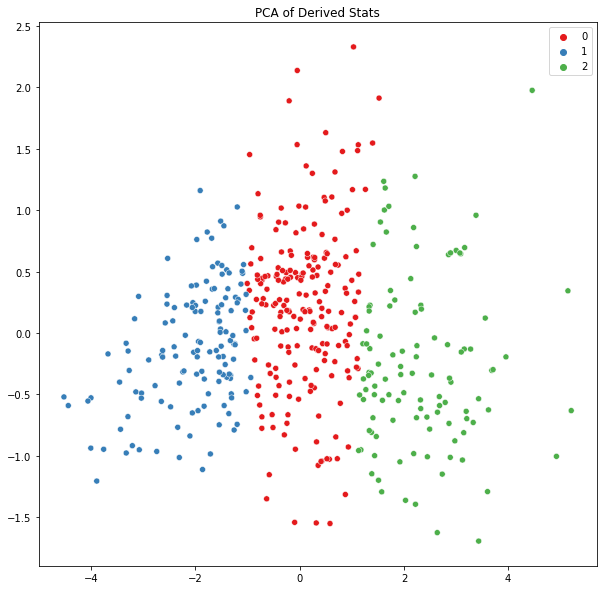

In [22]:
pca = PCA(n_components = 2)
derived_pca = pca.fit_transform(derived_scaled)

#from the WCSS graph above it is determined that the optimal number of clusters is around 3
km = KMeans(n_clusters = 3)
label_derived = km.fit_predict(derived_pca)

#plot the results of the transformed variables
plt.figure(figsize = (10,10))
sns.scatterplot(x = derived_pca[:,0], y = derived_pca[:,1], hue = label_derived, palette='Set1').set(title = "PCA of Derived Stats")

In [23]:
#plot the labels in the dataset, to preserve the most data, we will use runs created as opposed to WAR
#WAR is not available for all players in the total21 dataset
#print out all stats used in clustering to better understand the results
total21["labels_derived"] = label_derived
for i in total21["labels_derived"].unique():
    stats = total21.loc[total21["labels_derived"] == i]
    print("Statistics for Height, Weight, OPS, RC for cluster {}:".format(i))
    print(stats.agg({"height":["min","max","mean"], "weight":["min","max","mean"], "OBP":["min","max","mean"], "SLG":["min","max","mean"], "RC":["min","max","mean"]}))

Statistics for Height, Weight, OPS, RC for cluster 2:
         height      weight       OBP       SLG          RC
min   66.000000  160.000000  0.308874  0.378270   34.273270
max   79.000000  282.000000  0.465753  0.646809  144.245931
mean  73.256881  212.293578  0.358136  0.498924   86.100609
Statistics for Height, Weight, OPS, RC for cluster 0:
         height      weight       OBP       SLG         RC
min   68.000000  175.000000  0.273616  0.310606  10.240000
max   77.000000  277.000000  0.383886  0.558559  88.718182
mean  72.783654  209.004808  0.320133  0.406365  43.442235
Statistics for Height, Weight, OPS, RC for cluster 1:
         height      weight       OBP       SLG         RC
min   68.000000  140.000000  0.206522  0.207547   4.686857
max   79.000000  245.000000  0.330435  0.452381  43.360253
mean  72.699248  203.360902  0.272499  0.332340  19.317158


[Text(0.5, 1.0, 'PCA of Basic Stats')]

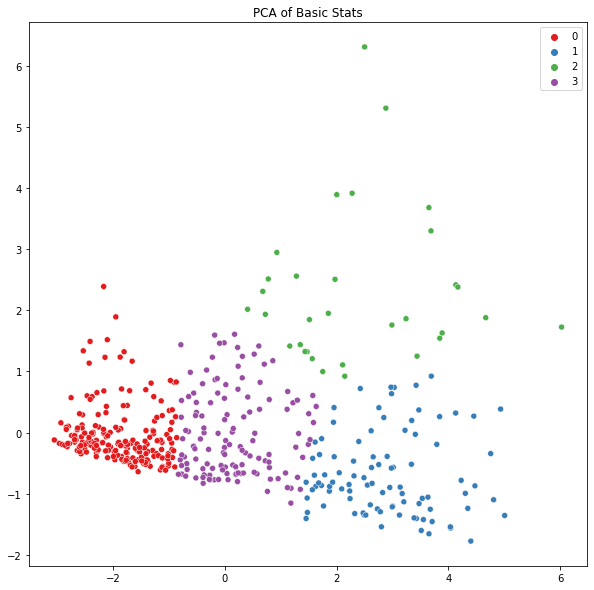

In [24]:
pca = PCA(n_components = 2)
basic_pca = pca.fit_transform(basic_scaled)

#from the WCSS plot above it is determined that the optimal number of clusters is between 3 and 4
km = KMeans(n_clusters = 4)
label_basic = km.fit_predict(basic_pca)

#plot the results of the transformed variables
plt.figure(figsize = (10,10))
sns.scatterplot(x = basic_pca[:,0], y = basic_pca[:,1], hue = label_basic, palette='Set1').set(title = "PCA of Basic Stats")

In [25]:
#plot the labels in the dataset, to preserve the most data, we will use runs created as opposed to WAR
#WAR is not available for all players in the total21 dataset
#print out all stats used in clustering to read the results better
total21["labels_basic"] = label_basic
for i in total21["labels_basic"].unique():
    stats = total21.loc[total21["labels_basic"] == i]
    print("Statistics for Height, Weight, OBP, SLG, RC for cluster {}:".format(i))
    print(stats.agg({"height":["min","max","mean"], "weight":["min","max","mean"], "OBP":["min","max","mean"], "SLG":["min","max","mean"], "RC":["min","max","mean"]}))

Statistics for Height, Weight, OBP, SLG, RC for cluster 1:
         height      weight       OBP       SLG          RC
min   66.000000  166.000000  0.280734  0.341593   52.325455
max   79.000000  282.000000  0.464832  0.614754  144.245931
mean  73.731183  219.053763  0.344465  0.484452   87.102427
Statistics for Height, Weight, OBP, SLG, RC for cluster 2:
        height     weight       OBP       SLG          RC
min   68.00000  165.00000  0.275862  0.324281   32.512997
max   76.00000  233.00000  0.394444  0.610879  125.088075
mean  72.09375  196.03125  0.334689  0.439023   79.322875
Statistics for Height, Weight, OBP, SLG, RC for cluster 0:
         height      weight       OBP       SLG         RC
min   68.000000  140.000000  0.206522  0.207547   4.686857
max   79.000000  270.000000  0.465753  0.623932  52.161622
mean  72.641026  204.917949  0.295086  0.362557  21.092543
Statistics for Height, Weight, OBP, SLG, RC for cluster 3:
      height      weight       OBP       SLG         RC


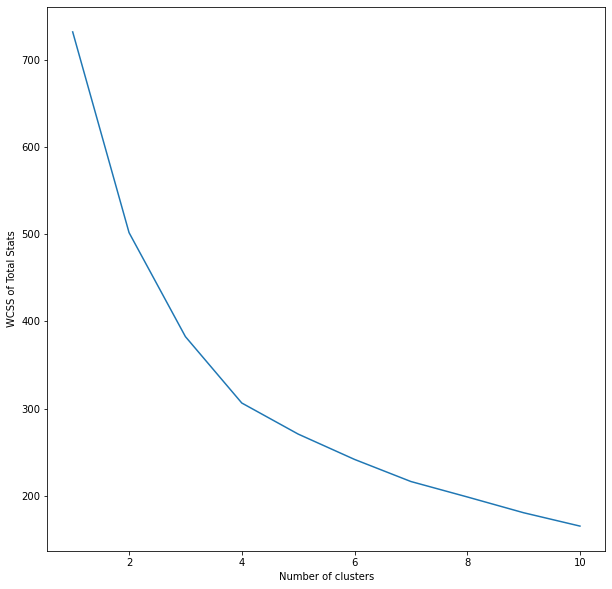

In [26]:
#create a WCSS graph for all stats
wcss_t = []
for i in range(1,11):
    model = KMeans(n_clusters = i, init = "k-means++")
    model.fit(total_scaled)
    wcss_t.append(model.inertia_)
    
plt.figure(figsize=(10,10))
plt.plot(range(1,11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS of Total Stats')
plt.show()

[Text(0.5, 1.0, 'PCA of Total Stats')]

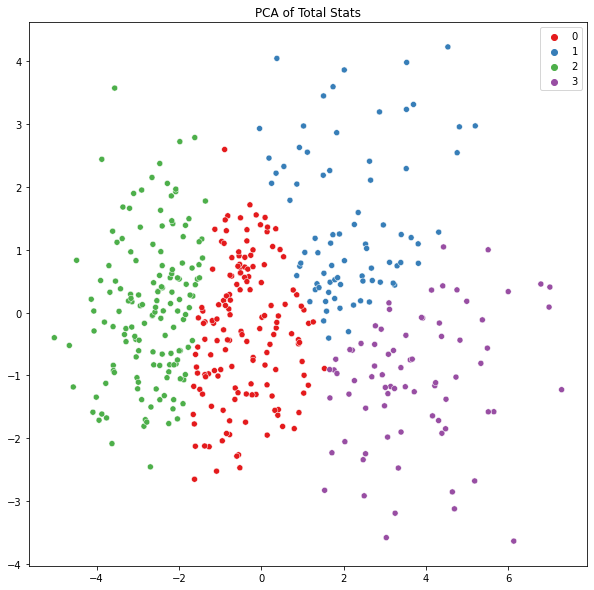

In [27]:
#PCA and cluster over all stats
pca = PCA(n_components = 2)
total_pca = pca.fit_transform(total_scaled)

#from the WCSS plot above it is determined that the optimal number of clusters is around 4
km = KMeans(n_clusters = 4)
label_total = km.fit_predict(total_pca)

#plot the results of the transformed variables
plt.figure(figsize = (10,10))
sns.scatterplot(x = total_pca[:,0], y = total_pca[:,1], hue = label_total, palette='Set1').set(title = "PCA of Total Stats")

In [28]:
total21["labels_total"] = label_total
for i in total21["labels_total"].unique():
    stats = total21.loc[total21["labels_total"] == i]
    print("Statistics for Height, Weight, OBP, SLG, RC for cluster {}:".format(i))
    print(stats.agg({"height":["min","max","mean"], "weight":["min","max","mean"], "OBP":["min","max","mean"], "SLG":["min","max","mean"], "RC":["min","max","mean"]}))

Statistics for Height, Weight, OBP, SLG, RC for cluster 3:
         height      weight       OBP       SLG          RC
min   70.000000  185.000000  0.281081  0.361809   52.325455
max   79.000000  282.000000  0.464832  0.614754  144.245931
mean  74.657895  226.631579  0.346993  0.497173   88.333244
Statistics for Height, Weight, OBP, SLG, RC for cluster 1:
        height      weight       OBP       SLG          RC
min   66.00000  160.000000  0.297420  0.324281   50.146606
max   75.00000  233.000000  0.401042  0.646809  118.492107
mean  71.56962  195.860759  0.342830  0.444800   75.101586
Statistics for Height, Weight, OBP, SLG, RC for cluster 2:
         height      weight       OBP       SLG         RC
min   68.000000  140.000000  0.206522  0.207547   4.686857
max   79.000000  245.000000  0.382353  0.495575  43.360253
mean  72.346939  200.238095  0.282848  0.342138  17.853808
Statistics for Height, Weight, OBP, SLG, RC for cluster 0:
         height      weight       OBP       SLG     

#### Linear Regressions
Finally, we will implement linear regression to determine the predictive power of different sets of statistics. As well as potentially calculate the value of one unit of RC and WAR.

In [29]:
#create a "scaled" dataset which will be used in regression
scaler.fit(final21[["RC", "WAR", "Salary"]])
scaled21 = pd.DataFrame()
scaled21[["RC", "WAR", "Salary"]] = scaler.transform(final21[["RC", "WAR", "Salary"]])

#basic stats to predict runs created
y1 = total21["RC"]
X1 = total21[basic]
A_basic = np.column_stack([np.ones(len(X1), dtype = 'int'), X1])
b_h_basic = np.linalg.inv(A_basic.T @ A_basic) @ A_basic.T @ y1

#basic stats to predict WAR
y2 = final21["WAR"]
X2 = final21[basic]
A_basic2 = np.column_stack([np.ones(len(X2), dtype = 'int'), X2])
b_h_basic2 = np.linalg.inv(A_basic2.T @ A_basic2) @ A_basic2.T @ y2

#salary to predict runs created
y3 = scaled21["Salary"]
X3 = scaled21["WAR"]
A_salary = np.column_stack([np.ones(len(X3), dtype = 'int'), X3])
b_h_salary = np.linalg.inv(A_salary.T @ A_salary) @ A_salary.T @ y3

#scaled salary to predict WAR
y4 = scaled21["WAR"]
X4 = scaled21["Salary"]
A_salary1 = np.column_stack([np.ones(len(X4), dtype = 'int'), X4])
b_h_salary1 = np.linalg.inv(A_salary1.T @ A_salary1) @ A_salary1.T @ y4

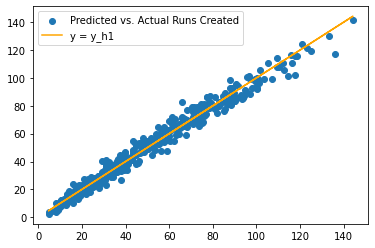

In [30]:
#predicting Runs Created based on basic statistics
y_h1 = A_basic @ b_h_basic

plt.scatter(y1, y_h1)
plt.plot(y1, y1, color = "orange")
plt.legend(["Predicted vs. Actual Runs Created", "y = y_h1"])
plt.show()

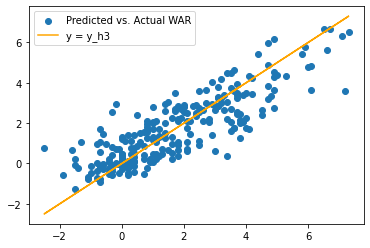

In [31]:
#predicting WAR based upon basic statistics
y_h2 = A_basic2 @ b_h_basic2

plt.scatter(y2, y_h2)
plt.plot(y2, y2, color = "orange")
plt.legend(["Predicted vs. Actual WAR", "y = y_h3"])
plt.show()

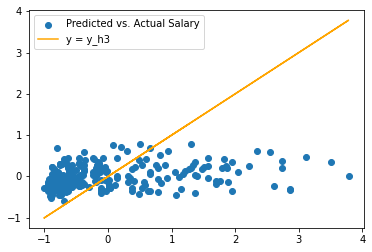

In [32]:
y_h3 = A_salary @ b_h_salary

plt.scatter(y3, y_h3)
plt.plot(y3, y3, color = "orange")
plt.legend(["Predicted vs. Actual Salary", "y = y_h3"])
plt.show()

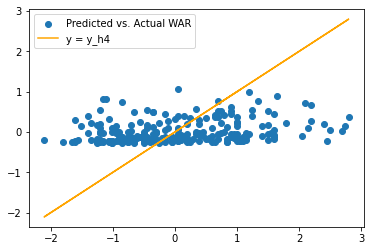

In [33]:
y_h4 = A_salary1 @ b_h_salary1

plt.scatter(y4, y_h4)
plt.plot(y4, y4, color = "orange")
plt.legend(["Predicted vs. Actual WAR", "y = y_h4"])
plt.show()

### Results: 

#### Results of Basic Data Analysis:
From the initial graphs of height and weight against OPS, we can see that OPS for players stays relatively consistent throughout the range of heights, but exhibits the most amount of consistency around the heights of 5'10" and 5'11". Average OPS by height does increase as players get taller, up until around 6'3", but so too does the range of players' OPS.

Weight is where the results become more interesting, as we can observe the variation in OPS stay relatively consistent, and increase as players' weights increase. A partial explanation for this phenomenon, which appears to imply that higher weight equals higher offensive production, would be that OPS by nature weights home runs quite heavily, and players who are heavier tend to have more muscle mass, enabling them to drive the ball further and result in more home runs. So while players who are heavier may hit the ball farther, their ability to hit home runs may obscure their shortcomings in other areas of the came, such as speed or defense, this is not accounted for in OPS and may explain what we see in the graph.

So from our intial observations, it can be understood that OPS favors size, which is why I also chose to analyze the distribution of WAR. WAR factors in offense as well as defense, and is generally considered a more holistic representation of a player's abilities, especially compared to their peers. 

Using WAR, I calculated WAR using two methods, one was to find the combination of height and weight which produced the highest WAR, the other was to find the height with the highest mean WAR, and then the weight with the highest mean WAR, and then find player which fit both height and weight values. The results of the first test produced a single player, Marcus Simien, who had a career year in 2021. Being the only player at his height and weight, his WAR is disproportionately represented in the results as there are no other players to average it out. The results of the second test identified players of height 6'2" (74 inches, mean WAR 2.2) and players of weight 190 lbs. (mean WAR 2.7) as having the highest mean WAR among all heights and weights with more than 10 players listed. Of the three players listed at this height an weight, the mean WAR is 2.666, which is slightly above the WAR of a league-average starting player, which hovers around 2.0.

Finally, I created a simple heat map which represents the height, weight, and WAR of MLB players in the final21 DataFrame. As we can see, there are two tiles that have a much higher mean WAR than others, these tiles each represent a single player: the aforementioned Marcus Simien, as well as superstar shortstop Trea Turner (listed at 6'2", 185 lbs.), who has a noticably low weight at his height (which contributes to his speed and defensive ability, hence his WAR). 

#### Results of Clustering & PCA:
The first example of clustering in this project was three-dimensional clustering on the variables height, weight, and WAR within the final21 DataFrame. The results are helpful for analyzing how height and weight plays a factor in a player's total production in the game of baseball. For example, cluster 4 represents the "superstars" of the game, with a mean cluster WAR of 4.2, this cluster is mostly composed of players who are all stars or even in the running for MVP, this helps explain the wide range of height and weight, with the cluster's height range being the widest of 5, as the game's elite players come in all shapes and sizes. The cluster with the next highest mean WAR is characterized by shorter and lighter players (mean WAR 3.0); the cluster in third place (mean WAR 2.2), is mostly populated by taller and heavier players. What is interesting to note in these results is that, although superstars of the game can vary greatly in height and weight, among players closer to the league average, we observe two distinct clusters, one composed of shorter and lighter players, while the other is composed of taller and heavier players, with the shorter players posessing a higher mean WAR by about 0.8.

The second set of graphs in the clustering section does employ PCA to reduce the dimensionality of the dataset for ease of clustering. The first graph in this particular section is the dimension-reduced scatterplot of derived statistics such as batting average, on base percentage, and slugging percentage. From the output regarding the characteristics of each cluster, it is interesting to note how the average height and weight of each cluster decreases along with offensive production numbers. The second graph in this section is a scatterplot based on the PCA results of basic statistics. This graph provides us with a better sense of the distribution of player statistics within the MLB, towards the lower left corner, we see denser clusters composed of below average to league-average players. As we move farther right, points start to fan out and here we can locate some of the league's more premier players. Again, we can note two major clusters among above-average players, one composed of, on average, taller and heavier players, and vice versa for the other cluster. 

The final graph in the clustering section combines all of the relevant statistics to create a scatterplot which incorporates height and weight into its clustering alongside both basic and derived statistics. The clustering results echoes that of the previous two graphs, as we once again can observe, from the 4 clusters that are formed), two which represent above average players but differ rather drastically in average weight and height, and two others which represent league average to below average players that hover around similar heights and weights.

#### Results of Linear Regression:
The graphs of linear regression in the prediction of both WAR and Runs Created can be looked at together, as opposed to predictions the graph helps us understand the variation between basic stats and the single summary statistics we use.

As we can see from the graph on Runs Created, our prediction line follows the data quite closely. This makes sense as RC is a statistic primarily derived from offensive statistics, many of which are partly composed of the set of "basic" stats defined above and used in this example of regression.

The graph of WAR is slightly more interesting, however, as the distribution of points appears to have a greater variation around the line of prediction compared to our RC graph. This indicates that there is a greater variation in WAR around basic statistics compared to a statistic like RC, further validating our point that WAR factors in more aspects of the game compared to Runs Created and is a more holistic representation of a player's performance.

The final two graphs in this notebook are an attempt to incorporate salary into regression-related predictions. From the first graph we can observe the regression results of predicting salary based upon a player's WAR. To the left hand side of the prediction line, we can observe a cluster of players who we can assume to be league average or below average. Moving slightly to the right we see players who are paid just about their worth, WAR-wise. And finally, on the far right are players who far exceeded the value of their contract in terms of WAR. A player in this area of the graph is likely to be a player on their rookie contract or one who is having a breakout year. The final graph in this notebook presents the results of attempting to use linear regression to predict a player's salary based on WAR. This graph illustrates the difficulty of judging a player's value on one statistic alone. From the distribution of points, we can see that the actual variation in WAR is much greater than the predicted variation. Thus displaying the lack of variation in salary compared to the variation in WAR within our dataset of available salaries and statistics.

To conclude the regression section, both of the final two graphs could benefit from experimentation with functional forms, manipulating either the *x* or the *y* variables to perhaps gain a better understanding of the distribution and make better predictions.

/var/folders/k6/97s742cj1sxgx6xqkr3d9dbr0000gn/T/ipykernel_80387/883248936.py:9: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


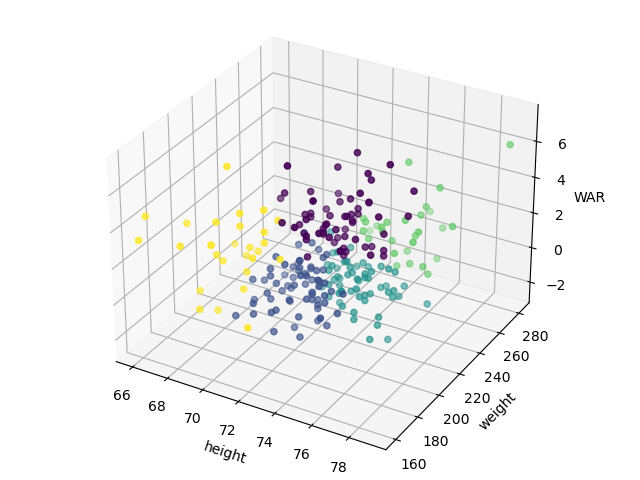

In [34]:
#code which enables interactive graphs, changes the presentation of all previous graphs if run
#prior to the code above
%matplotlib widget
  
# importing required libraries
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
  
# creating the plot
plt_3D = ax.scatter(final21.height, final21.weight, final21.WAR, c = war_labels)
ax.set_xlabel('height')
ax.set_ylabel('weight')
ax.set_zlabel('WAR')
plt.show()

### Conclusion: 

What we can conclude is that baseball players must be able to maximize their physical attributes if they wish to succeed. Bigger players must compensate for their tendency to lack speed and agility with strength and power, while smaller players compensate for their lack of strength through quickness and defensive prowess.

Through analysis, it can be observed that taller, heavier players tend to have better offensive numbers (OPS weight graph), but shorter players who weight less not only tend to be more consistent in their abilities (OPS height graph), but also tend to have a more well-rounded game (WAR heatmap). From clustering, we can also see that taller, heavier players have a tendency to perform better offensively. However, is must be noted that Runs Created (RC) is solely an offensive statistic and fails to account for a player's defensive presence, which is where smaller players tend to make up ground compared to their larger peers. 

Another observation to note is that, among starting-quality to above average players, there is a stark divide in height and weight which can almost always be observed in clustering results. As for average to below average players, however, their height and weight from clustering results almost always hovers around 72.5 ~ 73 inches (between 6'0" and 6'1") height-wise and around 205 lbs. in terms of weight.

We can conclude that, among players with above average offensive numbers, two classes of players: those that are shorter in height and lighter in weight (around 5'11" and 195 lbs.), and those that are taller and heavier (around 6'2" and 220 lbs.). While league average to below average players are typically around 71.5 inches (6'0"~6'1") height-wise and weigh roughly 205 lbs. with remarkable consistency. This answers the first question made in the introduction section of this notebook regarding the average build of an MLB player.

To answer the second question is a bit more difficult; from the clustering results, we can conclude that although it is possible for elite athletes of any size to succeed in Major League Baseball, the league tends to favor taller, heavier individuals as opposed to those who are closer to the population average in both categories, given that the average height of a male in the United States is around 5'9". 

*One final note is that this project would likely have benefitted from more years of data as well as more extensive WAR statistics. The limitations of using one year as a sample means missing out on variations in player performance year on year. Anamolies are omnipresent in professional sports, and many players have great years that simply can't be replicated later in their careers. The resulting numbers from those breakout or career-defining years may become outliers in projects like these which attempt to aggregate player performance across the board.*

### References: 

- All Lectures
- All Homework
- Python Documentation
- Seaborn Documentation
- https://www.seanlahman.com/baseball-archive/statistics/
- https://www.baseball-reference.com/leagues/majors/2021.shtml